# F2py

F2py is a part of Numpy and there are three ways to wrap Fortran with Python :
- Write some fortran subroutines and just run f2py to create Python modules.
- Insert special f2py directives inside Fortran source for complex wrapping.
- Write a interface file (.pyf) to wrap Fortran files without changing them. f2py automatically generate the pyf template file that can be modified. 

In [1]:
import os, sys

In [2]:
import matplotlib.pyplot as plt
import scipy.fftpack as sf
import scipy.linalg as sl
import numpy as np

## Simple Fortran subroutine to compute norm
   
### Fortran 90/95 free format

In [3]:
%%file euclidian_norm.f90
subroutine euclidian_norm (a, b, c)
  real(8), intent(in) :: a, b
  real(8), intent(out) :: c 
  c =	sqrt (a*a+b*b) 
end subroutine euclidian_norm

Overwriting euclidian_norm.f90


### Fortran 77 fixed format

In [4]:
%%file euclidian_norm.f
      subroutine euclidian_norm (a, b, c)
      real*8 a,b,c
Cf2py intent(out) c
      c = sqrt (a*a+b*b) 
      end 

Overwriting euclidian_norm.f


## Build extension module with f2py program


In [5]:
!{sys.executable} -m numpy.f2py --quiet -c euclidian_norm.f90 -m vect

/home/pnavaro/.julia/conda/3/x86_64/envs/f2py/lib/python3.11/site-packages/numpy/f2py/f2py2e.py:723: VisibleDeprecationWarning: 
distutils has been deprecated since NumPy 1.26.x
Use the Meson backend instead, or generate wrappers without -c and use a custom build script
  builder = build_backend(
WARN: Could not locate executable armflang
Removing build directory /tmp/tmpaoz6v48n


## Use the extension module in Python

In [6]:
import vect
c = vect.euclidian_norm(3,4)
c

5.0

In [7]:
print(vect.euclidian_norm.__doc__) # Docstring is automatically generate

c = euclidian_norm(a,b)

Wrapper for ``euclidian_norm``.

Parameters
----------
a : input float
b : input float

Returns
-------
c : float



## Fortran magic 

- Jupyter extension that help to use fortran code in an interactive session.
- It adds a %%fortran cell magic that compile and import the Fortran code in the cell, using F2py.
- The contents of the cell are written to a .f90 file in the directory IPYTHONDIR/fortran using a filename with the hash of the code. This file is then compiled. The resulting module is imported and all of its symbols are injected into the user's namespace.

[Documentation](http://nbviewer.jupyter.org/github/mgaitan/fortran_magic/blob/master/documentation.ipynb)

In [8]:
%load_ext fortranmagic

## F2py directives
- F2PY introduces also some extensions to Fortran 90/95 language specification that help designing Fortran to Python interface, make it more “Pythonic”.
- If editing Fortran codes is acceptable, these specific attributes can be inserted directly to Fortran source codes. Special comment lines are ignored by Fortran compilers but F2PY interprets them as normal lines.



In [9]:
%%fortran 
subroutine euclidian_norm(a,c,n) 
  integer :: n 
  real(8),dimension(n),intent(in) :: a
  !f2py optional , depend(a) :: n=len(a)
  real(8),intent(out) :: c 
  real(8) :: sommec 
  integer :: i
  sommec = 0 
  do i=1,n
    sommec=sommec+a( i )*a( i ) 
  end do
  c = sqrt (sommec) 
end subroutine euclidian_norm

In [10]:
a=[2,3,4]  # Python list
type(a)

list

In [11]:
euclidian_norm(a)

5.385164807134504

In [12]:
a=np.arange(2,5)  # numpy array
type(a)

numpy.ndarray

In [13]:
euclidian_norm(a)

5.385164807134504

In [14]:
print(euclidian_norm.__doc__) # Documentation

c = euclidian_norm(a,[n])

Wrapper for ``euclidian_norm``.

Parameters
----------
a : input rank-1 array('d') with bounds (n)

Other Parameters
----------------
n : input int, optional
    Default: shape(a, 0)

Returns
-------
c : float



## directives
- `optional`: The corresponding argument is moved to the end.
- `required`: This is default. Use it to disable automatic optional setting.
- `intent(in | inout | out | hide)` , `intent(in)` is the default.
- `intent(out)` is implicitly translated to `intent(out,hide) `.
- `intent(copy)` and `intent(overwrite)` control changes for input arguments.
- `check` performs some assertions, it is often automatically generated.
- `depend`:  f2py detects cyclic dependencies.
- `allocatable, parameter`
- `intent(callback), external`: for function as arguments.
- `intent(c)` C-type argument , array or function.
- C expressions: `rank, shape, len, size, slen`.


## Callback

You can call a python function inside your fortran code


In [15]:
%%fortran
subroutine sum_f (f ,n, s) 
  !Compute sum(f(i), i=1,n) 
  external f 
  integer, intent(in) :: n 
  real, intent(out) :: s
  s = 0.0 
  do i=1,n
    s=s+f(i)
  end do 
end subroutine sum_f

In [16]:
def fonction(i) : # python function
    return i*i

sum_f(fonction,3) 

14.0

In [17]:
sum_f(lambda x :x**2,3) # lambda function

14.0

## Fortran arrays and Numpy arrays

Let's see how to pass numpy arrays to fortran subroutine.


In [18]:
%%fortran --extra="-DF2PY_REPORT_ON_ARRAY_COPY=1"
subroutine push( positions, velocities, dt, n)
  integer, intent(in) :: n
  real(8), intent(in) :: dt
  real(8), dimension(n,3), intent(in) :: velocities
  real(8), dimension(n,3) :: positions
  do i = 1, n
    positions(i,:) = positions(i,:) + dt*velocities(i,:)
  end do
end subroutine push

In [19]:
positions = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
velocities = [[0, 1, 2], [0, 3, 2], [0, 1, 3]]

In [20]:
import sys
push(positions, velocities, 0.1)
positions # memory is not updated because we used C memory storage

created an array from object
created an array from object


[[0, 0, 0], [0, 0, 0], [0, 0, 0]]

During execution, the message "created an array from object" is displayed, because a copy of is made when passing multidimensional array to fortran subroutine.

In [21]:
positions = np.array(positions, dtype='f8', order='F')
push(positions, velocities, 0.1)
positions # the memory is updated

created an array from object


array([[0. , 0.1, 0.2],
       [0. , 0.3, 0.2],
       [0. , 0.1, 0.3]])

## Signature file

This file contains descriptions of wrappers to Fortran or C functions, also called as signatures of the functions. F2PY can create initial signature file by scanning Fortran source codes and catching all relevant information needed to create wrapper functions.

```bash
f2py vector.f90 -h vector.pyf
```
- vector.pyf

```fortran
!    -*- f90 -*-
! Note: the context of this file is case sensitive.

subroutine euclidian_norm(a,c,n) ! in vector.f90
    real(kind=8) dimension(n),intent(in) :: a
    real(kind=8) intent(out) :: c
    integer optional,check(len(a)>=n),depend(a) :: n=len(a)
end subroutine euclidian_norm

! This file was auto-generated with f2py (version:2).
! See http://cens.ioc.ee/projects/f2py2e/
```


## Wrap lapack function dgemm  with f2py

- Generate the signature file

In [22]:
!{sys.executable} -m numpy.f2py --quiet -m mylapack --overwrite-signature -h dgemm.pyf dgemm.f

rmbadname1: Replacing "max" with "max_bn".


```fortran
!    -*- f90 -*-
! Note: the context of this file is case sensitive.

python module mylapack ! in 
    interface  ! in :mylapack
        subroutine dgemm(transa,transb,m,n,k,alpha,a,lda,b,ldb,beta,c,ldc) ! in :mylapack:dgemm.f
            character*1 :: transa
            character*1 :: transb
            integer :: m
            integer :: n
            integer :: k
            double precision :: alpha
            double precision dimension(lda,*) :: a
            integer, optional,check(shape(a,0)==lda),depend(a) :: lda=shape(a,0)
            double precision dimension(ldb,*) :: b
            integer, optional,check(shape(b,0)==ldb),depend(b) :: ldb=shape(b,0)
            double precision :: beta
            double precision dimension(ldc,*) :: c
            integer, optional,check(shape(c,0)==ldc),depend(c) :: ldc=shape(c,0)
        end subroutine dgemm
    end interface 
end python module mylapack

! This file was auto-generated with f2py (version:2).
! See http://cens.ioc.ee/projects/f2py2e/
```

In [23]:
!{sys.executable} -m numpy.f2py --quiet -c dgemm.pyf -llapack -m mylapack

/home/pnavaro/.julia/conda/3/x86_64/envs/f2py/lib/python3.11/site-packages/numpy/f2py/f2py2e.py:723: VisibleDeprecationWarning: 
distutils has been deprecated since NumPy 1.26.x
Use the Meson backend instead, or generate wrappers without -c and use a custom build script
  builder = build_backend(
WARN: Could not locate executable armflang
Removing build directory /tmp/tmpvk_r2iu4


In [24]:
import numpy as np
import mylapack
a = np.array([[7,8],[3,4],[1,2]])
b = np.array([[1,2,3],[4,5,6]])
print("a=",a) 
print("b=",b)
assert a.shape[1] == b.shape[0]
c = np.zeros((a.shape[0],b.shape[1]),'d',order='F')
mylapack.dgemm('N','N',a.shape[0],b.shape[1],a.shape[1],1.0,a,b,1.0,c)
print(c)
np.all(c == a @ b) # check with numpy matrix multiplication 

a= [[7 8]
 [3 4]
 [1 2]]
b= [[1 2 3]
 [4 5 6]]
[[39. 54. 69.]
 [19. 26. 33.]
 [ 9. 12. 15.]]


np.True_

### Exercise 
- Modify the file dgemm.pyf to set all arguments top optional and keep only the two matrices as input.

In [25]:
%%file dgemm2.pyf
python module mylapack2 ! in 
    interface  ! in :mylapack
        subroutine dgemm(transa,transb,m,n,k,alpha,a,lda,b,ldb,beta,c,ldc)
            character, optional :: transa = 'N'
            character, optional :: transb = 'N'
            integer, optional :: m = shape(a,0)
            integer, optional :: n = shape(b,1)
            integer, optional, check(shape(b,0)==k) :: k = shape(a,1)
            double precision, optional :: alpha = 1.
            double precision dimension(lda,*) :: a
            integer optional,check(shape(a,0)==lda),depend(a) :: lda=shape(a,0)
            double precision dimension(ldb,*) :: b
            integer optional,check(shape(b,0)==ldb),depend(b) :: ldb=shape(b,0)
            double precision, optional :: beta = 1.
            double precision dimension(shape(a,0),shape(b,1)), intent(out) :: c
            integer optional :: ldc=shape(a,0)
        end subroutine dgemm
    end interface 
end python module mylapack2

Overwriting dgemm2.pyf


## Build the python module

In [26]:
!{sys.executable} -m numpy.f2py --quiet -c dgemm2.pyf  -m mylapack2 -llapack --f90flags=-O3

/home/pnavaro/.julia/conda/3/x86_64/envs/f2py/lib/python3.11/site-packages/numpy/f2py/f2py2e.py:723: VisibleDeprecationWarning: 
distutils has been deprecated since NumPy 1.26.x
Use the Meson backend instead, or generate wrappers without -c and use a custom build script
  builder = build_backend(
WARN: Could not locate executable armflang
Removing build directory /tmp/tmpsv7r5y41


In [27]:
import mylapack2
a = np.array([[7,8],[3,4],[1,2]])
b = np.array([[1,2,3],[4,5,6]])
c = mylapack2.dgemm(a,b)
np.all( c == a @ b)

np.True_

## Check performance between numpy and mylapack

In [28]:
a = np.random.random((512,128))
b = np.random.random((128,512))

In [29]:
%timeit c = mylapack2.dgemm(a,b)

756 μs ± 2.17 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [30]:
%timeit c = a @ b

1.51 ms ± 210 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


**Fortran arrays allocated in a subroutine share same memory in Python**

In [31]:
%%fortran
module f90module
   implicit none
   real(8), dimension(:),   allocatable :: farray
contains
   subroutine init( n ) !Allocation du tableau farray
   integer, intent(in) :: n
   allocate(farray(n))
   end subroutine init
end module f90module

In [32]:
f90module.init(10)
len(f90module.farray)

10

**Numpy arrays allocated in Python passed to Fortran are already allocated**

In [33]:
%%fortran
module f90module
   implicit none
   real(8), dimension(:),   allocatable :: farray
contains
   subroutine test_array( allocated_flag, array_size )
   logical, intent(out) :: allocated_flag
   integer, intent(out) :: array_size
   allocated_flag = allocated(farray)
   array_size = size(farray)
   end subroutine test_array
end module f90module

In [34]:
f90module.farray = np.random.rand(10).astype(np.float64)
f90module.test_array()

(1, 10)

## f2py + OpenMP



In [35]:
import os, sys

%env OMP_NUM_THREADS=4
if sys.platform == "darwin":
    os.environ["CC"] = "gcc-10"
    os.environ["FC"] = "gfortran"

env: OMP_NUM_THREADS=4


In [36]:
%%fortran 
subroutine hello( )
  integer :: i
  do i = 1, 4
    call sleep(1)
  end do
end subroutine

In [37]:
%%time
hello()

CPU times: user 24.1 ms, sys: 44.5 ms, total: 68.6 ms
Wall time: 4 s


In [38]:
%%fortran --f90flags='-fopenmp' --extra='-lgomp'
subroutine hello_omp( )
  use omp_lib
  integer :: i
  !$OMP PARALLEL PRIVATE(I)
  !$OMP DO 
  do i = 1, 4
    call sleep(1)
  end do
  !$OMP END DO
  !$OMP END PARALLEL

end subroutine hello_omp

In [39]:
%%time
hello_omp()

CPU times: user 8.49 ms, sys: 8.8 ms, total: 17.3 ms
Wall time: 1 s


## Conclusions

- Easy to use, it works with modern fortran, legacy fortran and also C.
- Works with common and modules and arrays dynamically allocated.
- Python function callback can be very useful combined with Sympy
- Documentation is  automatically generated
- All fortran compilers are supported: GNU, Portland, Sun, Intel,...
- F2py is integrated in numpy library.

## cons 
- Derived types and fortran pointers are not well supported.
- Absolutely not compatible with fortran 2003-2008 new features (classes)
- f2py is maintained but not really improved. Development is stopped.

## distutils

- setup.py
```python
from numpy.distutils.core import Extension, setup
ext1 = Extension(name = 'scalar',
                 sources = ['scalar.f'])
ext2 = Extension(name = 'fib2',
                 sources = ['fib2.pyf','fib1.f'])

setup(name = 'f2py_example', ext_modules = [ext1,ext2])
```
Compilation
```bash
python3 setup.py build_ext --inplace
```

### Exercice: Laplace problem

- Replace the `laplace` function by a fortran subroutine

iterations =  2457
CPU times: user 12.6 s, sys: 9.01 ms, total: 12.6 s
Wall time: 12.6 s


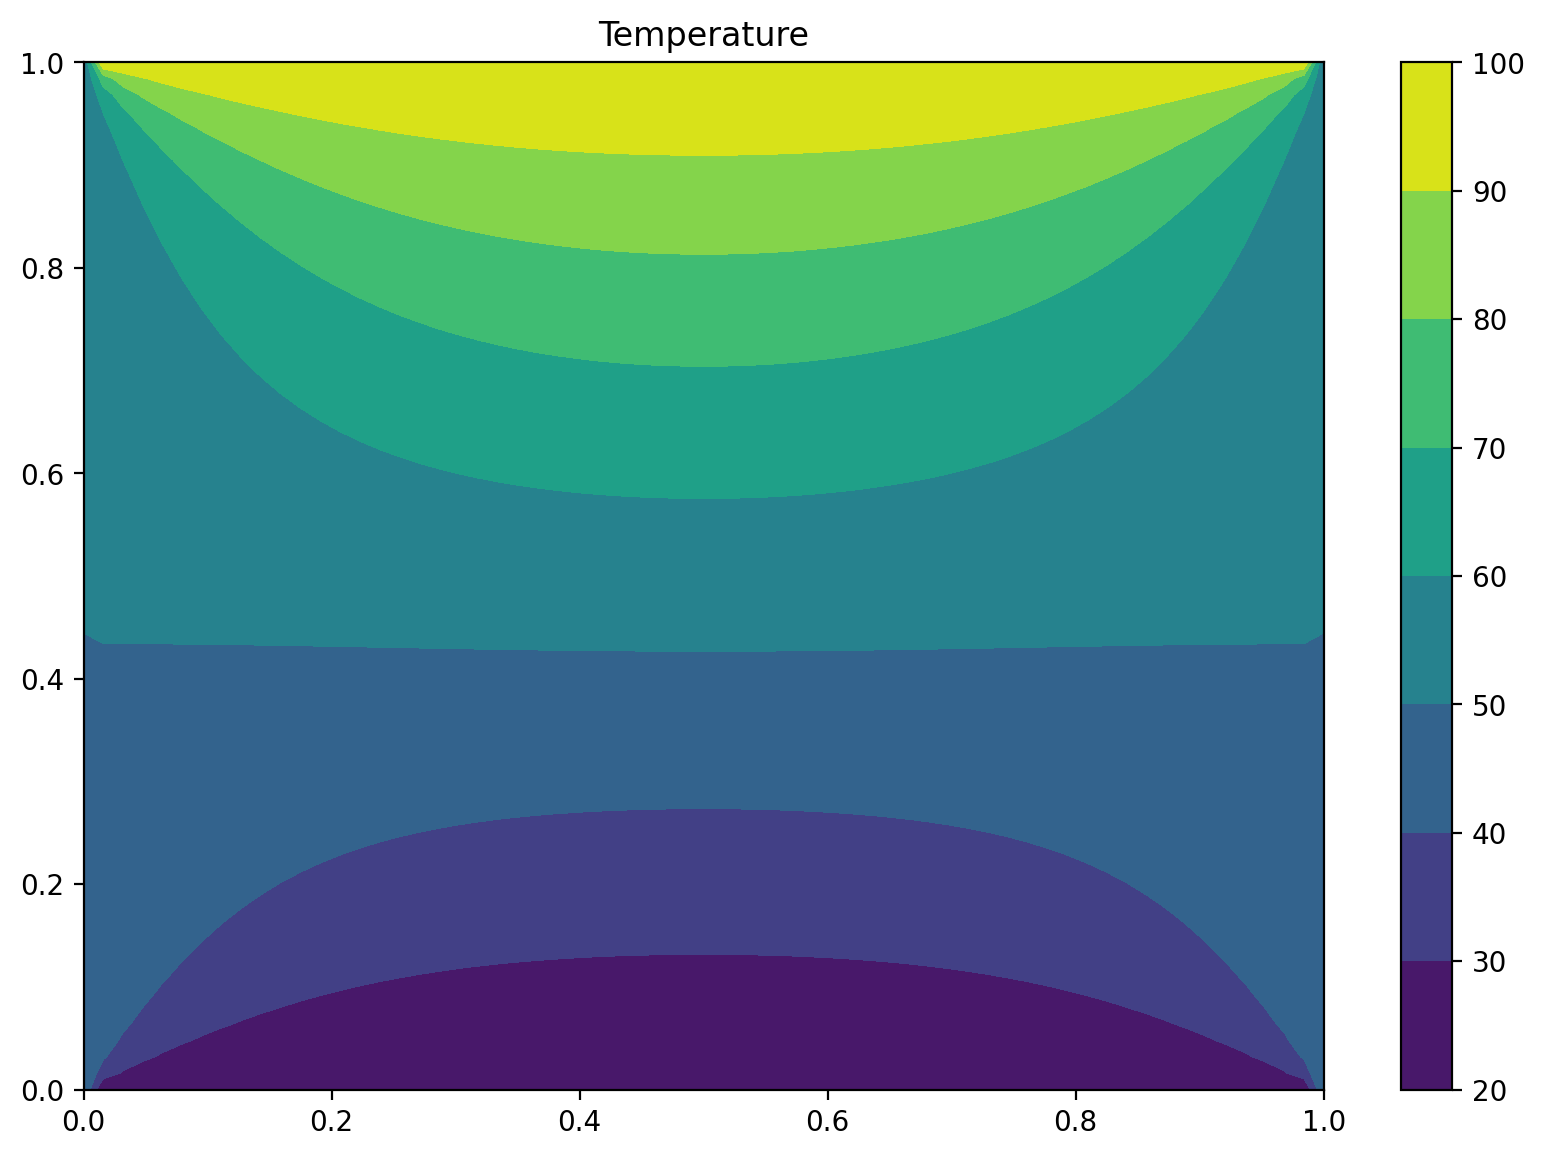

In [40]:
%%time
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import itertools
# Boundary conditions
Tnorth, Tsouth, Twest, Teast = 100, 20, 50, 50

# Set meshgrid
n, l = 64, 1.0
X, Y = np.meshgrid(np.linspace(0,l,n), np.linspace(0,l,n))
T = np.zeros((n,n))

# Set Boundary condition
T[n-1:, :] = Tnorth
T[:1, :] = Tsouth
T[:, n-1:] = Teast
T[:, :1] = Twest

def laplace(T, n):
    residual = 0.0
    for i in range(1, n-1):
        for j in range(1, n-1):
            T_old = T[i,j]
            T[i, j] = 0.25 * (T[i+1,j] + T[i-1,j] + T[i,j+1] + T[i,j-1])
            if T[i,j]>0:
                residual=max(residual,abs((T_old-T[i,j])/T[i,j]))
    return residual

residual = 1.0   
istep = 0
while residual > 1e-5 :
    istep += 1
    residual = laplace(T, n)
    # print ((istep, residual), end="\r")

print("iterations = ",istep)
plt.rcParams['figure.figsize'] = (10,6.67)
plt.title("Temperature")
plt.contourf(X, Y, T)
plt.colorbar()

In [41]:
%%fortran
subroutine laplace_fortran( T, n, residual )

  real(8), intent(inout) :: T(0:n-1,0:n-1) ! Python indexing
  integer, intent(in)    :: n
  real(8), intent(out)   :: residual
  real(8) :: T_old
              
  residual = 0.0
  do i = 1, n-2  
    do j = 1, n-2
        T_old = T(i,j)
        T(i, j) = 0.25 * (T(i+1,j) + T(i-1,j) + T(i,j+1) + T(i,j-1))
            if (T(i,j) > 0) then
                residual=max(residual,abs((T_old-T(i,j))/T(i,j)))
            end if
    end do
  end do
        
end subroutine laplace_fortran


iterations =  2457
CPU times: user 59.8 ms, sys: 0 ns, total: 59.8 ms
Wall time: 58.5 ms


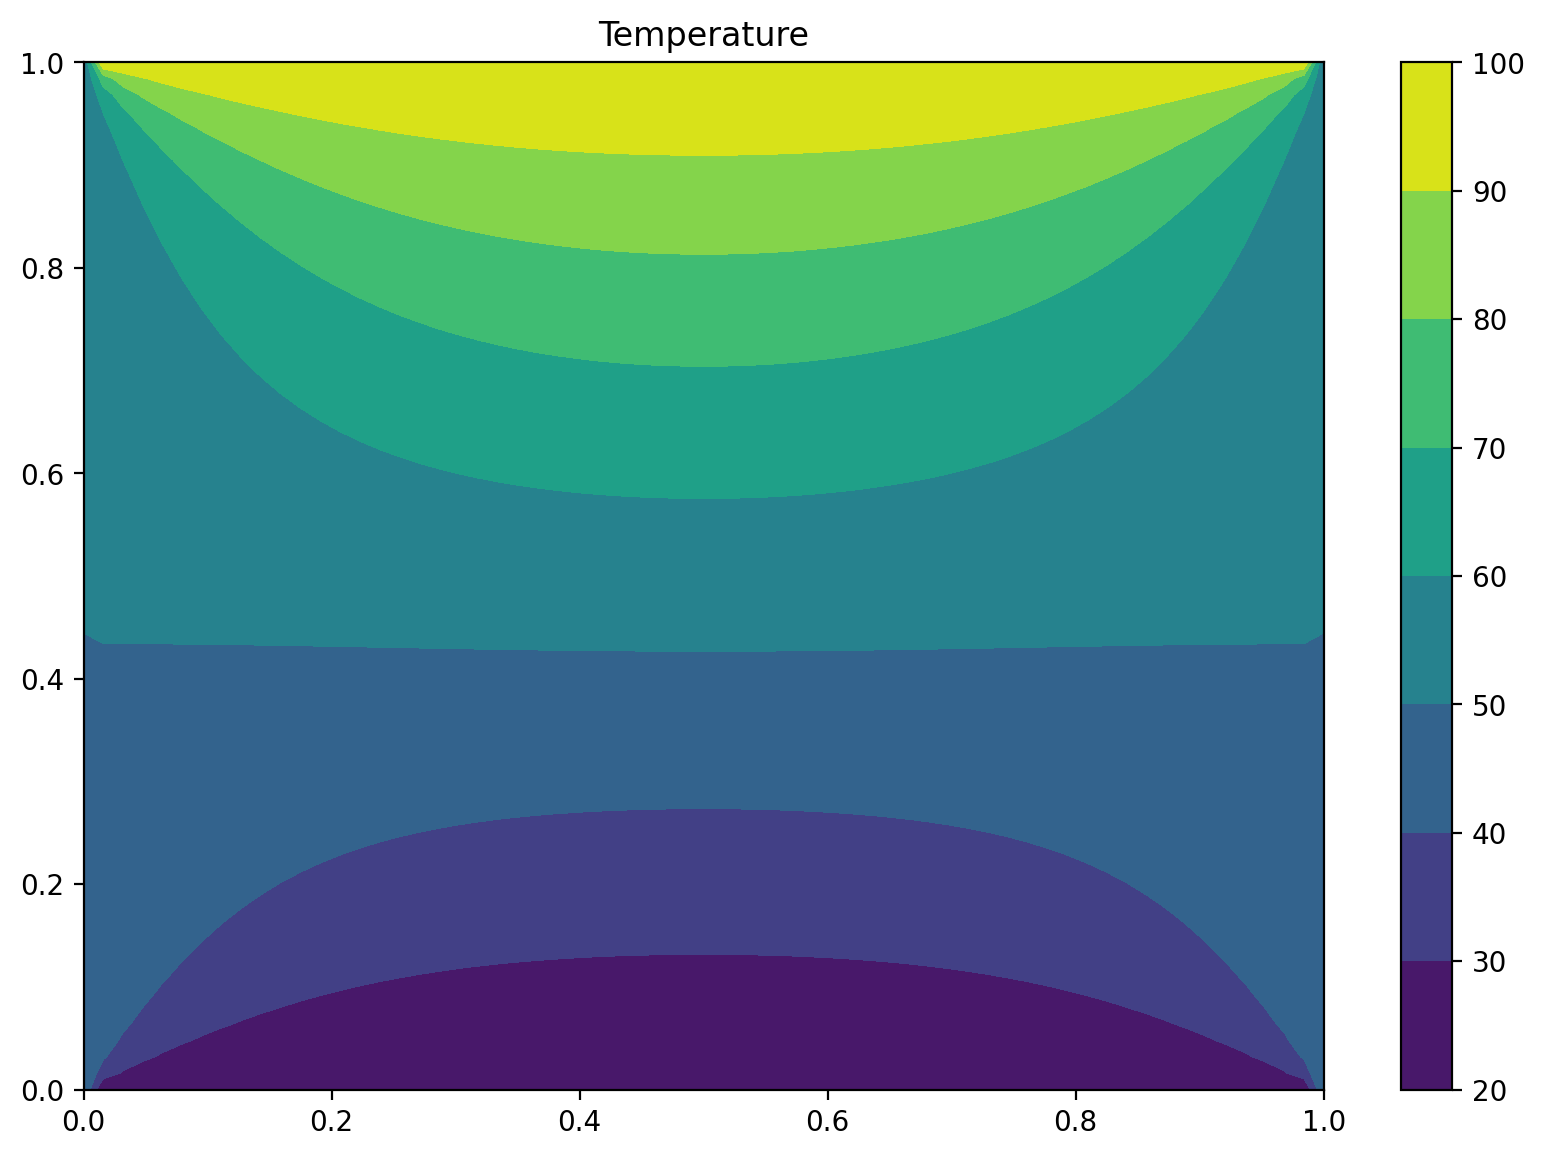

In [42]:
%%time
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import itertools
# Boundary conditions
Tnorth, Tsouth, Twest, Teast = 100, 20, 50, 50

# Set meshgrid
n, l = 64, 1.0
X, Y = np.meshgrid(np.linspace(0,l,n), np.linspace(0,l,n))
T = np.zeros((n,n), order='F')  ## We need to declare a new order in memory

# Set Boundary condition
T[n-1:, :] = Tnorth
T[:1, :] = Tsouth
T[:, n-1:] = Teast
T[:, :1] = Twest

residual = 1.0   
istep = 0
while residual > 1e-5 :
    istep += 1
    residual = laplace_fortran(T, n)

print()
print("iterations = ",istep)
plt.rcParams['figure.figsize'] = (10,6.67)
plt.title("Temperature")
plt.contourf(X, Y, T)
plt.colorbar()

## References
- [Talk by E. Sonnendrücker](http://calcul.math.cnrs.fr/Documents/Journees/dec2006/python-fortran.pdf)
- [SciPy](http://www.scipy.org/F2py)
- [Sagemath Documentation ](http://www.sagemath.org/doc/numerical_sage/f2py.html) 
- Hans Petter Langtangen. *Python Scripting for Computational Science*. Springer 2004


## Add extra flags like bounds checking

```
python3 setup.py config_fc --f90flags=-fbounds-check
```

In setup.py

```
ext1 = Extension(name='_coffee_f90',
                 sources=files1,
                 extra_f90_compile_args=['-fbounds-check'],
                 extra_link_args=['-llapack -lgomp'])
```
